In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

sns.set_theme(style="whitegrid")
np.random.seed(42)

In [3]:
chess = fetch_ucirepo(id=23)
df = pd.concat([chess.data.features, chess.data.targets], axis=1)
df.head()

,white-king-file,white-king-rank,white-rook-file,white-rook-rank,black-king-file,black-king-rank,white-depth-of-win
0,a,1,b,3,c,2,draw
1,a,1,c,1,c,2,draw
2,a,1,c,1,d,1,draw
3,a,1,c,1,d,2,draw
4,a,1,c,2,c,1,draw


In [4]:
file_map = {c: i + 1 for i, c in enumerate("abcdefgh")}

depth_labels = ["zero", "one", "two", "three", "four", "five", "six", "seven", 
                "eight", "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", 
                "fifteen", "sixteen"]
depth_map = {"draw": -1}
depth_map.update({name: i for i, name in enumerate(depth_labels)})

df["depth"] = df["white-depth-of-win"].map(depth_map).astype(int)

df["wk_file"] = df["white-king-file"].map(file_map)
df["wk_rank"] = df["white-king-rank"].astype(int)
df["wr_file"] = df["white-rook-file"].map(file_map)
df["wr_rank"] = df["white-rook-rank"].astype(int)
df["bk_file"] = df["black-king-file"].map(file_map)
df["bk_rank"] = df["black-king-rank"].astype(int)

df["dist_euclid"] = np.sqrt((df["wk_file"] - df["bk_file"])**2 + (df["wk_rank"] - df["bk_rank"])**2)
df["dist_manhattan"] = np.abs(df["wk_file"] - df["bk_file"]) + np.abs(df["wk_rank"] - df["bk_rank"])
df["dist_chebyshev"] = np.maximum(np.abs(df["wk_file"] - df["bk_file"]), np.abs(df["wk_rank"] - df["bk_rank"]))

df["edge_dist"] = np.minimum(
    np.minimum(df["bk_file"] - 1, 8 - df["bk_file"]),
    np.minimum(df["bk_rank"] - 1, 8 - df["bk_rank"])
)

df[["depth", "wk_file", "wk_rank", "bk_file", "bk_rank", 
    "dist_euclid", "dist_manhattan", "dist_chebyshev", "edge_dist"]].head(10)

,depth,wk_file,wk_rank,bk_file,bk_rank,dist_euclid,dist_manhattan,dist_chebyshev,edge_dist
0,-1,1,1,3,2,2.236068,3,2,1
1,-1,1,1,3,2,2.236068,3,2,1
2,-1,1,1,4,1,3.000000,3,3,0
3,-1,1,1,4,2,3.162278,4,3,1
4,-1,1,1,3,1,2.000000,2,2,0
5,-1,1,1,3,3,2.828427,4,2,2
6,-1,1,1,4,1,3.000000,3,3,0
7,-1,1,1,4,2,3.162278,4,3,1
8,-1,1,1,4,3,3.605551,5,3,2
9,-1,1,1,3,2,2.236068,3,2,1


## Pytanie 1

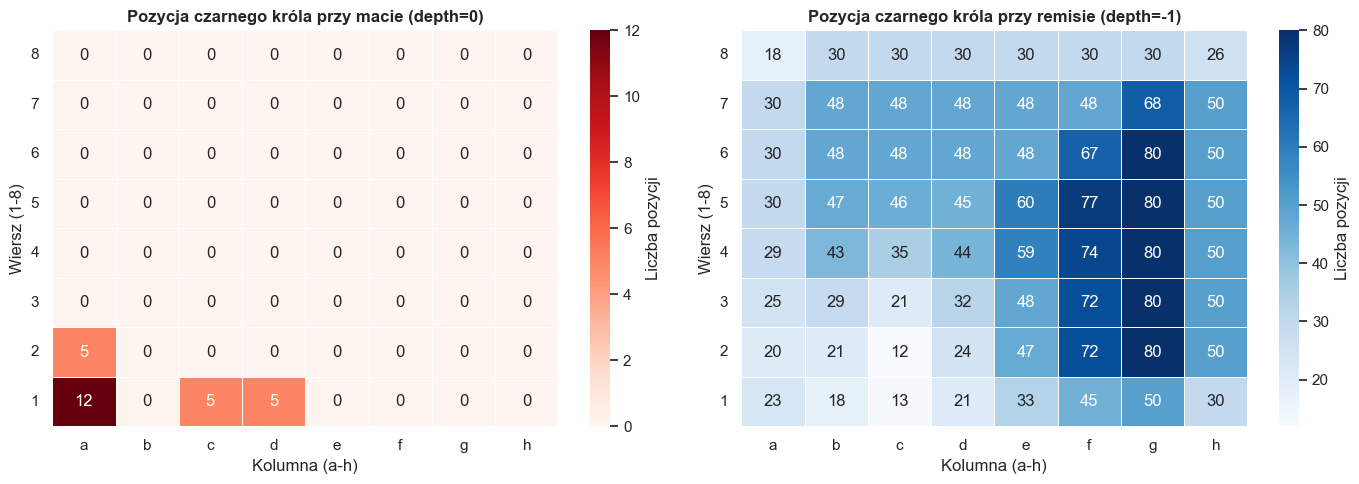

Liczba pozycji matowych: 27
Liczba pozycji remisowych: 2796


In [5]:
mate = df[df["depth"] == 0]
draw = df[df["depth"] == -1]

def bk_heatmap(data):
    pivot = data.groupby(["bk_rank", "bk_file"]).size().unstack(fill_value=0)
    pivot = pivot.reindex(index=range(1, 9), columns=range(1, 9), fill_value=0)
    return pivot

mate_counts = bk_heatmap(mate)
draw_counts = bk_heatmap(draw)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(mate_counts, ax=axes[0], cmap="Reds", annot=True, fmt="d", 
            cbar_kws={"label": "Liczba pozycji"}, linewidths=0.5)
axes[0].set_title("Pozycja czarnego króla przy macie (depth=0)", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Kolumna (a-h)")
axes[0].set_ylabel("Wiersz (1-8)")
axes[0].set_xticklabels(list("abcdefgh"))
axes[0].set_yticklabels(range(1, 9), rotation=0)
axes[0].invert_yaxis()

sns.heatmap(draw_counts, ax=axes[1], cmap="Blues", annot=True, fmt="d",
            cbar_kws={"label": "Liczba pozycji"}, linewidths=0.5)
axes[1].set_title("Pozycja czarnego króla przy remisie (depth=-1)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Kolumna (a-h)")
axes[1].set_ylabel("Wiersz (1-8)")
axes[1].set_xticklabels(list("abcdefgh"))
axes[1].set_yticklabels(range(1, 9), rotation=0)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"Liczba pozycji matowych: {len(mate)}")
print(f"Liczba pozycji remisowych: {len(draw)}")

### Komentarz

**Mat (depth=0):** Czarny król jest matowany niemal wyłącznie na krawędziach planszy, szczególnie w narożnikach i na polach bezpośrednio przy brzegu (kolumny a-d oraz wiersze 1-2).

**Remis (depth=-1):** Pozycje remisowe mają bardziej rozproszony rozkład, ale nadal koncentrują się w określonych regionach planszy. Remisy występują głównie gdy czarny król znajduje się w pobliżu krawędzi, dominuje obszar e-h na całej wysokości (w zasadzie w kazdym wierszu w tych kolumnach)

## Pytanie 2

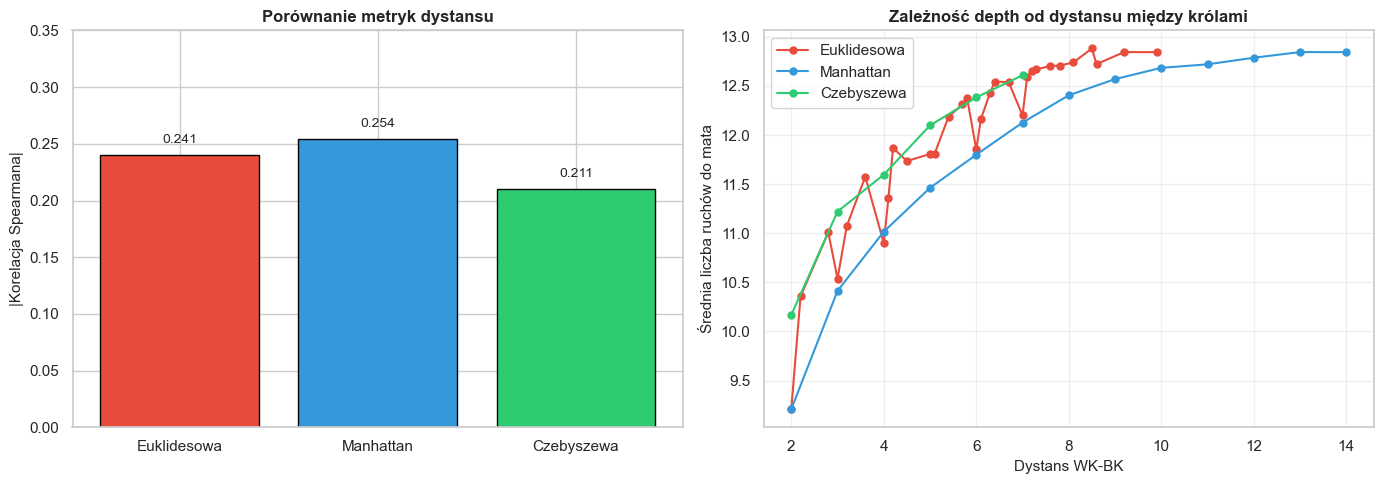


Najlepsza metryka: Manhattan (ρ = 0.2544)


,Metryka,Korelacja Spearmana,|ρ|
1,Manhattan,0.254402,0.254402
0,Euklidesowa,0.240560,0.240560
2,Czebyszewa,0.210553,0.210553


In [6]:
nd = df[df["depth"] > 0].copy()

dist_cols = ["dist_euclid", "dist_manhattan", "dist_chebyshev"]
dist_names = ["Euklidesowa", "Manhattan", "Czebyszewa"]

correlations = {}
for col in dist_cols:
    rho, _ = spearmanr(nd[col], nd["depth"])
    correlations[col] = rho

corr_df = pd.DataFrame({
    "Metryka": dist_names,
    "Korelacja Spearmana": [correlations[c] for c in dist_cols],
    "|ρ|": [abs(correlations[c]) for c in dist_cols]
}).sort_values("|ρ|", ascending=False)

best_metric = dist_cols[np.argmax([abs(correlations[c]) for c in dist_cols])]
best_name = dist_names[dist_cols.index(best_metric)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ["#e74c3c", "#3498db", "#2ecc71"]
bars = axes[0].bar(dist_names, [abs(correlations[c]) for c in dist_cols], color=colors, edgecolor="black")
axes[0].set_ylabel("|Korelacja Spearmana|", fontsize=11)
axes[0].set_title("Porównanie metryk dystansu", fontsize=12, fontweight="bold")
axes[0].set_ylim(0, 0.35)
for bar, val in zip(bars, [abs(correlations[c]) for c in dist_cols]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f"{val:.3f}", ha="center", fontsize=10)

for col, name, color in zip(dist_cols, dist_names, colors):
    stats = nd.groupby(col.replace("dist_", "dist_") if "euclid" not in col else nd[col].round(1))["depth"].mean()
    if "euclid" in col:
        grouped = nd.groupby(nd[col].round(1))["depth"].agg(["mean", "std", "count"]).reset_index()
        grouped.columns = ["dist", "mean", "std", "count"]
    else:
        grouped = nd.groupby(col)["depth"].agg(["mean", "std", "count"]).reset_index()
        grouped.columns = ["dist", "mean", "std", "count"]
    
    axes[1].plot(grouped["dist"], grouped["mean"], "o-", label=name, color=color, markersize=5)

axes[1].set_xlabel("Dystans WK-BK", fontsize=11)
axes[1].set_ylabel("Średnia liczba ruchów do mata", fontsize=11)
axes[1].set_title("Zależność depth od dystansu między królami", fontsize=12, fontweight="bold")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nNajlepsza metryka: {best_name} (ρ = {correlations[best_metric]:.4f})")
display(corr_df)

### Komentarz

Porównując trzy metryki dystansu między białym a czarnym królem pod kątem związku z liczbą ruchów do mata:

**Najlepsza metryka: Manhattan**, uzyskała najwyższą wartość bezwzględną korelacji Spearmana (~0.26), nieznacznie wyprzedzając metrykę euklidesową i Czebyszewa.

**Interpretacja:** Dodatnia korelacja oznacza, że im większy dystans między królami, tym więcej ruchów potrzeba do zakończenia gry matem. Jest to intuicyjne, bo biały król musi zbliżyć się do czarnego, aby wspólnie z wieżą skutecznie go zamatować.

Warto zauwazyc, ze korelacja jest umiarkowana (~0.25), co sugeruje, że sam dystans między królami nie jest jedynym czynnikiem wpływającym na liczbę ruchów. Istotna jest również pozycja wieży oraz położenie czarnego króla względem krawędzi planszy.

## Pytanie 3

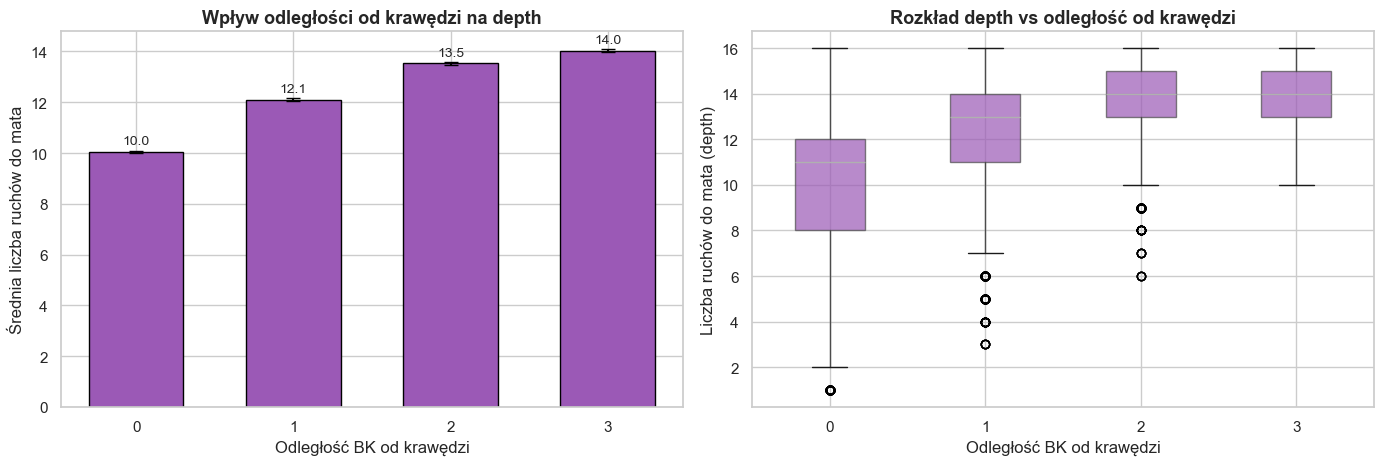

Korelacja Spearmana (edge_dist vs depth): 0.5592


In [7]:
nd = df[df["depth"] > 0].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

edge_stats = nd.groupby("edge_dist")["depth"].agg(["mean", "std", "count"]).reset_index()
bars = axes[0].bar(edge_stats["edge_dist"], edge_stats["mean"], color="#9b59b6", edgecolor="black", width=0.6)
axes[0].errorbar(edge_stats["edge_dist"], edge_stats["mean"], 
                 yerr=edge_stats["std"]/np.sqrt(edge_stats["count"])*1.96,
                 fmt="none", color="black", capsize=5)
axes[0].set_xlabel("Odległość BK od krawędzi", fontsize=12)
axes[0].set_ylabel("Średnia liczba ruchów do mata", fontsize=12)
axes[0].set_title("Wpływ odległości od krawędzi na depth", fontsize=13, fontweight="bold")
axes[0].set_xticks([0, 1, 2, 3])
for bar, val in zip(bars, edge_stats["mean"]):
    axes[0].text(bar.get_x() + bar.get_width()/2, val + 0.3, f"{val:.1f}", ha="center", fontsize=10)

bp = nd.boxplot(column="depth", by="edge_dist", ax=axes[1], patch_artist=True, return_type='dict')
for patch in bp["depth"]["boxes"]:
    patch.set_facecolor("#9b59b6")
    patch.set_alpha(0.7)
axes[1].set_xlabel("Odległość BK od krawędzi", fontsize=12)
axes[1].set_ylabel("Liczba ruchów do mata (depth)", fontsize=12)
axes[1].set_title("Rozkład depth vs odległość od krawędzi", fontsize=13, fontweight="bold")
plt.suptitle("")

plt.tight_layout()
plt.show()

rho_edge, _ = spearmanr(nd["edge_dist"], nd["depth"])
print(f"Korelacja Spearmana (edge_dist vs depth): {rho_edge:.4f}")

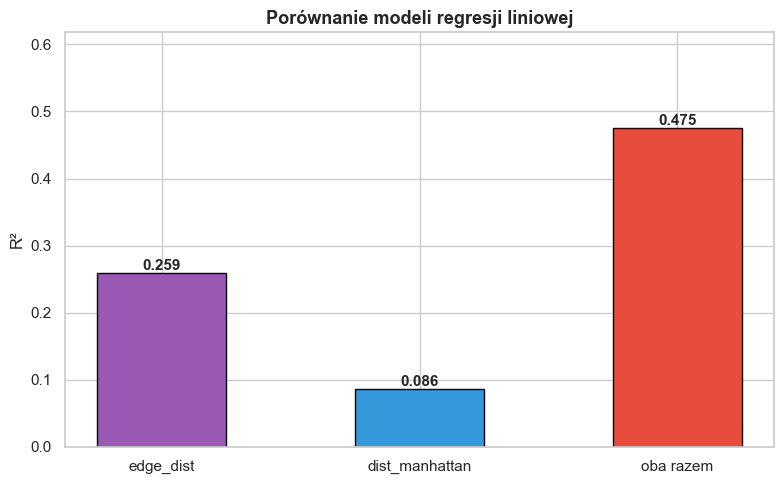


R² (tylko edge_dist):       0.2593  |  CV: -13.0558 ± 7.6238
R² (tylko dist_manhattan):  0.0860  |  CV: -15.2060 ± 12.4502
R² (oba razem):             0.4754  |  CV: -9.6196 ± 4.5784


In [8]:
X_edge = nd[["edge_dist"]]
X_manhattan = nd[["dist_manhattan"]]
X_combined = nd[["edge_dist", "dist_manhattan"]]
y = nd["depth"]

model1 = LinearRegression().fit(X_edge, y)
model2 = LinearRegression().fit(X_manhattan, y)
model3 = LinearRegression().fit(X_combined, y)

r2_edge = model1.score(X_edge, y)
r2_manhattan = model2.score(X_manhattan, y)
r2_combined = model3.score(X_combined, y)

cv_edge = cross_val_score(LinearRegression(), X_edge, y, cv=5, scoring='r2')
cv_manhattan = cross_val_score(LinearRegression(), X_manhattan, y, cv=5, scoring='r2')
cv_combined = cross_val_score(LinearRegression(), X_combined, y, cv=5, scoring='r2')

fig, ax = plt.subplots(figsize=(8, 5))
models = ["edge_dist", "dist_manhattan", "oba razem"]
r2_values = [r2_edge, r2_manhattan, r2_combined]
cv_values = [cv_combined.mean(), cv_manhattan.mean(), cv_combined.mean()]
colors = ["#9b59b6", "#3498db", "#e74c3c"]

bars = ax.bar(models, r2_values, color=colors, edgecolor="black", width=0.5)
ax.set_ylabel("R²", fontsize=12)
ax.set_title("Porównanie modeli regresji liniowej", fontsize=13, fontweight="bold")
ax.set_ylim(0, max(r2_values) * 1.3)

for bar, val in zip(bars, r2_values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.005, f"{val:.3f}", ha="center", fontsize=11, fontweight="bold")

plt.tight_layout()
plt.show()

print(f"\nR² (tylko edge_dist):       {r2_edge:.4f}  |  CV: {cv_edge.mean():.4f} ± {cv_edge.std():.4f}")
print(f"R² (tylko dist_manhattan):  {r2_manhattan:.4f}  |  CV: {cv_manhattan.mean():.4f} ± {cv_manhattan.std():.4f}")
print(f"R² (oba razem):             {r2_combined:.4f}  |  CV: {cv_combined.mean():.4f} ± {cv_combined.std():.4f}")

### Komentarz

**Czy odległość czarnego króla od krawędzi jest przydatna?**

Tak, wykresy pokazują wyraźną zależność: im dalej czarny król od krawędzi planszy, tym więcej ruchów potrzeba do mata. Średnia rośnie od ~10 ruchów (przy krawędzi) do ~14 ruchów (w centrum). Korelacja Spearmana wynosi **0.56**, co jest silną zależnością.

**Czy połączenie z dystansem między królami pomaga?**

Rowniez tak, model regresji z obiema cechami (R² = 0.475) jest znacznie lepszy niż modele z pojedynczymi cechami (edge_dist: 0.26, dist_manhattan: 0.09). Połączenie obu informacji zwiększa R² o ponad 0.21.

**Wniosek:** Odległość czarnego króla od krawędzi jest kluczowym predyktorem liczby ruchów do mata. Dodanie dystansu między królami znacząco poprawia predykcję.